In [1]:
import numpy as np
import pandas as pd
import os

We have a problem regarding calculating player similarity. Games have different lengths and different amounts of players, it's not possible to compare them if they have irregular formats. Hence we are going to create embeddings for each player rich in information to "sumarize" their behaviour with other players and during the game.

In [2]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
max_rows = 0
max_columns = 0
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    max_rows = max(max_rows, game.shape[0])
    max_columns = max(max_columns, data.NUMBER_OF_PARTICIPANTS * 2 - 1)
max_rows, max_columns

(10710, np.int64(15))

We will fill the lack of information (due to a game being shorter or having less people) with zeros.

In [3]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
rows = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    inter_player_columns = game.columns[game.columns.str.match(f'P._TO_P.')]
    interaction_players = game[inter_player_columns].mean().mean()
    for id in range(1, data.NUMBER_OF_PARTICIPANTS+1):
        p1_looks = game.columns[game.columns.str.match(f'P{id}_TO_.[^{id}]')]
        p1_looked = game.columns[game.columns.str.match(f'P[^{id}]_TO_P{id}')]
        unpadded = game[[*p1_looks, *p1_looked]].values

        padded_array = np.zeros((max_rows, max_columns))
        padded_array[:unpadded.shape[0], :unpadded.shape[1]] = unpadded
        row = padded_array.flatten()
        
        rows.append(row)
        
df = pd.DataFrame(rows)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,160640,160641,160642,160643,160644,160645,160646,160647,160648,160649
0,0.534,0.046,0.083,0.000,0.041,0.029,0.067,0.023,0.030,0.049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.077,0.023,0.127,0.011,0.025,0.034,0.503,0.046,0.041,0.019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.079,0.030,0.041,0.039,0.041,0.037,0.533,0.083,0.127,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100,0.049,0.019,0.063,0.073,0.377,0.120,0.000,0.011,0.039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043,0.034,0.040,0.357,0.020,0.050,0.256,0.041,0.025,0.041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0.023,0.047,0.096,0.021,0.313,0.244,0.027,0.029,0.014,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.083,0.070,0.109,0.080,0.057,0.177,0.074,0.150,0.246,0.499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,0.037,0.039,0.031,0.066,0.126,0.374,0.053,0.074,0.056,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.004,0.048,0.079,0.049,0.024,0.059,0.519,0.019,0.064,0.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we create the model that will generate the embeddings.

In [42]:
from keras import models
from keras import layers
from keras import regularizers

input_layer = layers.Input(shape=(max_rows * max_columns,))

# Encoder
encoded = layers.Dense(24, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.5)(encoded)
encoded = layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(encoded)

# Embedding Layer (we choose such a low dimension because there are only 451 data points, and we want to avoid overfitting)
embedding = layers.Dense(3, activation='sigmoid', name='embedding')(encoded)

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(embedding)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dropout(0.5)(decoded)
decoded = layers.Dense(24, activation='sigmoid')(decoded)
output_layer = layers.Dense(max_rows * max_columns, activation='sigmoid')(decoded)

# Split into encoder and autoencoder models
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
encoder = models.Model(inputs=input_layer, outputs=embedding)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    df.values,
    df.values, 
    epochs=32, 
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Now we can use the encoder to generate embeddings for players
player_embeddings = encoder.predict(df.values)


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 160650)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 24)             │     3,855,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 160650)         │     4,016,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,872,477 (30.03 MB)

 Trainable params: 7,872,413 (30.03 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2281 - val_loss: 0.2006
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1973 - val_loss: 0.1806
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1793 - val_loss: 0.1644
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1624 - val_loss: 0.1490
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1481 - val_loss: 0.1351
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1336 - val_loss: 0.1203
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1200 - val_loss: 0.1088
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1084 - val_loss: 0.0978
Epoch 9/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0971 - val_loss: 0.0869
Epoch 10/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0865 - val_loss: 0.0778
Epoch 11/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0778 - val_loss: 0.0689
Epoch 12/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0

<Axes: xlabel='y', ylabel='z'>

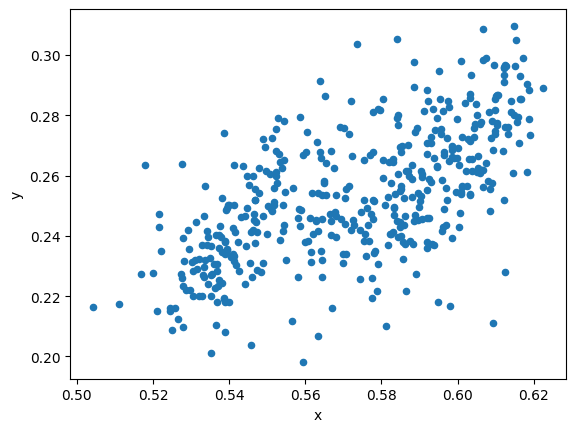

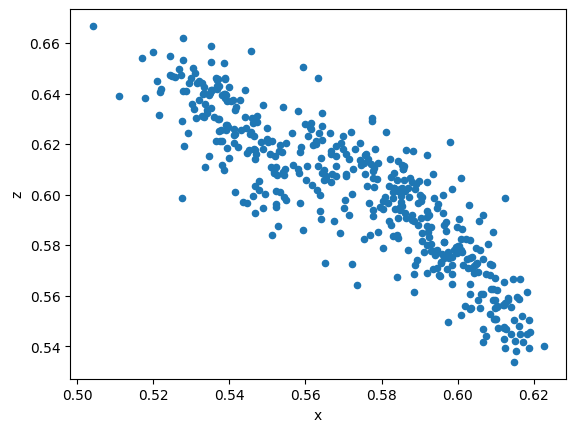

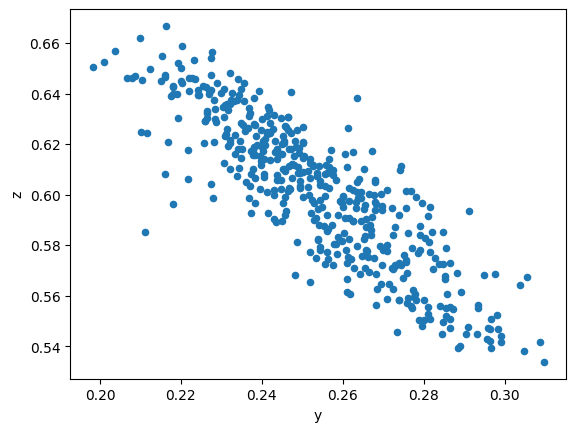

In [44]:
player_embeddings
df_player_embeddings = pd.DataFrame(
    player_embeddings,
    columns=[
        'x',
        'y',
        'z',
    ]
)
df_player_embeddings.plot.scatter(x='x', y='y')
df_player_embeddings.plot.scatter(x='x', y='z')
df_player_embeddings.plot.scatter(x='y', y='z')

# As we can see, the embeddings have repeated information, but not enough such that we should drop a dimension.

<Axes: ylabel='Frequency'>

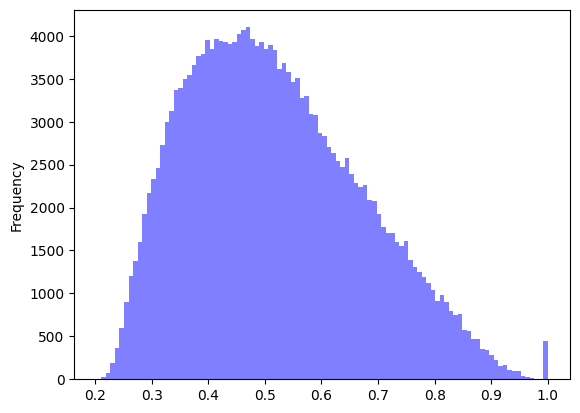

In [ ]:
from scipy.spatial.distance import pdist,squareform
distances = squareform(pdist(player_embeddings, metric='euclidean'))
q = 0.5 
# Adjust such that half of the similarities are under 0.5 ignoring self-similarities
similarities = 1/(1+distances*(q**-1 - 1)/np.quantile(distances[~np.eye(distances.shape[0], dtype=bool)], q))
pd.Series(similarities.flatten()).plot.hist(bins=100, alpha=0.5, color='blue', label='Euclidean') 
# Tiene buena pinta

In [52]:
# Quitamos similitudes con uno mismo
similarities[np.eye(similarities.shape[0], dtype=bool)] = 0
similarities

array([[0.        , 0.72838982, 0.35608515, ..., 0.40301656, 0.53474954,
        0.40508951],
       [0.72838982, 0.        , 0.40828752, ..., 0.46844212, 0.64998768,
        0.47036777],
       [0.35608515, 0.40828752, 0.        , ..., 0.73632872, 0.51209039,
        0.72057891],
       ...,
       [0.40301656, 0.46844212, 0.73632872, ..., 0.        , 0.61981172,
        0.96144406],
       [0.53474954, 0.64998768, 0.51209039, ..., 0.61981172, 0.        ,
        0.62537831],
       [0.40508951, 0.47036777, 0.72057891, ..., 0.96144406, 0.62537831,
        0.        ]])

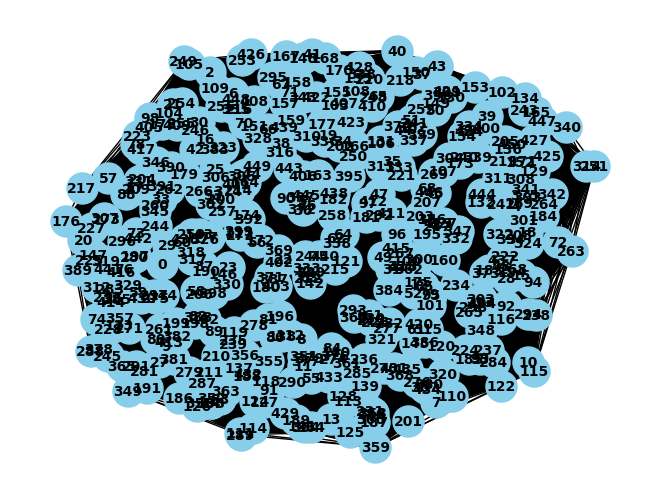

In [53]:
import networkx as nx
G = nx.Graph(similarities)
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')

In [54]:
nx.write_gml(G, 'comm-f2f-Resistance/embeddings.gml')